In [1]:
# In The Name of God -


In [2]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

In [3]:
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive texlive-fonts-recommended
import os
from matplotlib.pyplot import text
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,028 kB]
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,590 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:

In [4]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files

manual_seed = 20
image_size = 64
use_whole_dataset = True
usage_percent = 1.0
celeba_male_index = 20
celeba_young_index = 39
celeba_smiling_index = 31
celeba_straight_hair_index = 32
celeba_wavy_hair_index = 33
celeba_black_hair_index = 8
celeba_blonde_hair_index = 9
celeba_brown_hair_index = 11
celeba_gray_hair_index = 17
celeba_eyeglasses_index = 15
celeba_chubby_index = 13
celeba_mouth_open_index = 21
celeba_high_cheekbone_index = 19

learning_rate = 0.001 #0.2
batch_size = 1 #64

# ------------- GS
p2r_model_number = 183
utl_model_number = 6

p2r_dir = 'p2r-ae-9rev2-G-S'
p2r_model_path = 'drive/MyDrive/jam4/' + p2r_dir + '/'
utl_dir = 'adv-trn-2-S-NLLLoss'
utl_model_path = 'drive/MyDrive/ML/saves/' + utl_dir + '/'

save_dir = 'decor-rev2-test-2'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasetShortcuts/CelebA'
data_dir = 'celeba'

#----------------
using_index = celeba_smiling_index
use_g = True
g_eff_val = -3000
miu = 0
coef_for_var = 0

# Other params
# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Size of feature maps in encoder
nef = 64
# Size of feature maps in decoder
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3

In [5]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

# download dataset and unzip
# data_dir variable: data_dir = 'img_align_celeba'
dataset_zip_path = dataset_folder_path + '/Img/img_align_celeba.zip'
list_eval_partition_path = dataset_folder_path + '/Eval/list_eval_partition.txt'
identity_celeba_path = dataset_folder_path + '/Anno/identity_CelebA.txt'
list_attr_celeba_path = dataset_folder_path + '/Anno/list_attr_celeba.txt'
list_bbox_celeba_path = dataset_folder_path + '/Anno/list_bbox_celeba.txt'
list_landmarks_align_celeba_path = dataset_folder_path + '/Anno/list_landmarks_align_celeba.txt'

if files_not_ready:
    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_zip_path, data_dir + r'/img_align_celeba.zip')
    shutil.copyfile(list_eval_partition_path, data_dir + r'/list_eval_partition.txt')
    shutil.copyfile(identity_celeba_path, data_dir + r'/identity_CelebA.txt')
    shutil.copyfile(list_attr_celeba_path, data_dir + r'/list_attr_celeba.txt')
    shutil.copyfile(list_bbox_celeba_path, data_dir + r'/list_bbox_celeba.txt')
    shutil.copyfile(list_landmarks_align_celeba_path, data_dir + r'/list_landmarks_align_celeba.txt')

    try:
        shutil.rmtree(data_dir + r'/img_align_celeba')
        print("old unzipped directory removed successfully")
    except OSError as e:
        print("Error: %s" % (e.strerror))

    archive = data_dir + r'/img_align_celeba.zip'
    with ZipFile(archive, 'r') as zip:
       zip.extractall(data_dir)
try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

data folder created successfully
Error: No such file or directory
Error: File exists


In [8]:
# Define transforms
train_transforms = transforms.Compose([transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [9]:
# Load Datas
train_set = datasets.CelebA(root='', download=False, split='train', target_type=["attr", "identity"], transform=train_transforms)
test_set = datasets.CelebA(root='', download=False, split='test', target_type=["attr", "identity"], transform=test_transforms)
valid_set = datasets.CelebA(root='', download=False, split='valid', target_type=["attr", "identity"], transform=test_transforms)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=workers)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=workers)


In [10]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [11]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu

        # input is nc x 64 x 64
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # split features: 1024 -> 1022 + 2 (male/female)
        # first classifier: (gender)
        self.fllc_male_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_male_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features1 = nn.Dropout(p=0.5)
        self.fllc_male_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_male_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_male_features2 = nn.Dropout(p=0.5)
        self.fllc_male_features3 = nn.Linear(nef*4, nef)
        self.actv_male_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_male_features4 = nn.Linear(nef, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features1 = nn.Dropout(p=0.5)
        self.fllc_other_features2 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_other_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_other_features2 = nn.Dropout(p=0.5)
        self.fllc_other_features3 = nn.Linear(nef*1*4*4, nef*1*4*4 - 2)
        self.actv_other_features3 = nn.LeakyReLU(0.2, inplace=True)
        # aggregate features for output

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # first classifier: (gender)
        y1 = self.fllc_male_features1(x)
        y1 = self.actv_male_features1(y1)
        y1 = self.dropout_male_features1(y1)
        y1 = self.fllc_male_features2(y1)
        y1 = self.actv_male_features2(y1)
        y1 = self.dropout_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # other features
        y3 = self.fllc_other_features1(x)
        y3 = self.actv_other_features1(y3)
        y3 = self.dropout_other_features1(y3)
        y3 = self.fllc_other_features2(y3)
        y3 = self.actv_other_features2(y3)
        y3 = self.dropout_other_features2(y3)
        y3 = self.fllc_other_features3(y3)
        y3 = self.actv_other_features3(y3)
        return y1, y3

In [12]:
# Decoder Model
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu

        # input size is 1024
        self.fllc6 = nn.Linear(nef*1*4*4, ndf*2*4*4)
        self.actv6 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 2048
        # shaping would be here: 2048 -> ndf*2 x 4 x 4
        # state size. (ndf*2) x 4 x 4
        self.cnvt7 = nn.ConvTranspose2d( ndf*2, ndf, 4, 2, 1, bias=False)
        self.bnor7 = nn.BatchNorm2d(ndf)
        self.actv7 = nn.ReLU(True)
        # state size. (ndf) x 8 x 8
        self.cnvt8 = nn.ConvTranspose2d(ndf, ndf, 4, 2, 1, bias=False)
        self.bnor8 = nn.BatchNorm2d(ndf)
        self.actv8 = nn.ReLU(True)
        # state size. (ndf) x 16 x 16
        self.cnvt9 = nn.ConvTranspose2d( ndf, ndf, 4, 2, 1, bias=False)
        self.bnor9 = nn.BatchNorm2d(ndf)
        self.actv9 = nn.ReLU(True)
        # state size. (ndf) x 32 x 32
        self.cnvt10 = nn.ConvTranspose2d( ndf, nc, 4, 2, 1, bias=False)
        self.actv10 = nn.Sigmoid()
        # state size. (nc) x 64 x 64

    def forward(self, x):
        x = self.fllc6(x)
        x = self.actv6(x)
        x = x.view(batch_size, ndf*2, 4, 4) # 64 is batch_size
        x = self.cnvt7(x)
        x = self.bnor7(x)
        x = self.actv7(x)
        x = self.cnvt8(x)
        x = self.bnor8(x)
        x = self.actv8(x)
        x = self.cnvt9(x)
        x = self.bnor9(x)
        x = self.actv9(x)
        x = self.cnvt10(x)
        x = self.actv10(x)
        return x

In [13]:
# AE Model + Noise
class AEModel(nn.Module):
    def __init__(self, ngpu, mode='train', miu=0, coef_for_var=0, g_eff_val=-3000):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        self.g_eff_val = g_eff_val
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.mode = mode
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def tune_noise(self, miu=0, coef_for_var=0, g_eff_val=-3000):
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.g_eff_val = g_eff_val

    def change_mode(self, mode='train'):
        self.mode = mode

    def add_noise(self, nodes):
      with torch.no_grad():
        var = (self.coef_for_var) * (torch.mean(nodes).item())
        noise = self.miu + (var) * torch.randn(nodes.size())
        noise = noise.to(device)
        nodes.add_(noise)
        return nodes

    def change_lbl(self, nodes, lbls):
      with torch.no_grad():
        lbls[lbls == 0] = self.g_eff_val
        lbls[lbls == 1] = 0
        nodes = lbls
        return nodes

    def forward(self, x, y1_real_lbl=[]):
        if create_random_pics:
            yy = []
            yy = self.change_lbl(yy, y1_real_lbl)
            y = torch.cat((yy, x), 1)
            pic = self.decoder(y)
            return pic, yy
        else:
            y1, y3 = self.encoder(x)
            if self.mode=='use':
                if use_g:
                  # y1 = y1_real_lbl 
                  y1 = self.change_lbl(y1, y1_real_lbl)
                y3 = self.add_noise(y3)
            y = torch.cat((y1, y3), 1)
            x = self.decoder(y)
            return x, y1, y3

In [14]:
# Utilizer Model 
class UtlModel(nn.Module):
    def __init__(self, ngpu):
        super(UtlModel, self).__init__()
        self.ngpu = ngpu
        
        # input is nc x 64 x 64 
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # classifier:
        self.fllc_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features1 = nn.Dropout(p=0.5)
        self.fllc_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features2 = nn.Dropout(p=0.5)
        self.fllc_features3 = nn.Linear(nef*4, nef)
        self.actv_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_features4 = nn.Linear(nef, 2)
        self.actv_features4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # classifier: 
        y1 = self.fllc_features1(x)
        y1 = self.actv_features1(y1)
        y1 = self.dropout_features1(y1)
        y1 = self.fllc_features2(y1)
        y1 = self.actv_features2(y1)
        y1 = self.dropout_features2(y1)
        y1 = self.fllc_features3(y1)
        y1 = self.actv_features3(y1)
        y1 = self.fllc_features4(y1)
        y1 = self.actv_features4(y1)
        return y1

In [15]:
# Create the networks
netAE = AEModel(ngpu).to(device)
utilizerModel = UtlModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))
    utilizerModel = nn.DataParallel(utilizerModel, list(range(ngpu)))

In [16]:
#@title
# Function - Load:
def load_model(saving_path, name, number, model, device):

  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [17]:
# Load Last Checkpoint:
ae_load = load_model(p2r_model_path, 'ae', p2r_model_number, netAE, device)
utl_load = load_model(utl_model_path, 'adv', utl_model_number, utilizerModel, device)

In [18]:
def extract_targets(labels):
    male_labels =  labels[0][:, using_index]
    female_labels = torch.add(1, -male_labels)
    # gender_target = torch.cat((male_labels.view(batch_size,1), female_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    gender_target = torch.cat((female_labels.view(batch_size,1), male_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    gender_target = gender_target.to(device)
    return gender_target

In [19]:
def calc_miu_var_for_middle_layer(my_loader):
  y3_values = []
  y1_values = []
  prog_bar = tqdm(enumerate(my_loader), total=len(my_loader))
  with torch.no_grad():
    for i, data in prog_bar:
      inputs, labels = data[0], data[1]
      inputs = inputs.to(device)
      gender_target = extract_targets(labels)
      output, y1, y3 = netAE.forward(inputs, gender_target)
      y3_values.append(y3)
      y1_values.append(y1)
  return y3_values, y1_values

In [20]:
# Calculate mean and var for middle layer
expriment_based_on_noise = False
if expriment_based_on_noise:
  create_random_pics = False
  netAE.change_mode('use')
  netAE.eval()

  netAE.tune_noise(miu, coef_for_var, g_eff_val)
  y3_out, y1_out = calc_miu_var_for_middle_layer(test_loader)
  T = torch.cat(y3_out)
  T_mean = torch.mean(T, axis = 0)
  T_var = torch.var(T, axis = 0)

  T_y1 = torch.cat(y1_out)
  T_y1_mean = torch.mean(T_y1, axis = 0)
  T_y1_var = torch.var(T_y1, axis = 0)

    # create random pics for utility attr equals to 1 and 0
  T_mean, T_var = T_mean.to(device), T_var.to(device)
  create_random_pics = True
  netAE.tune_noise(miu, coef_for_var, g_eff_val=-100000000)
  utl_acc = []
  round = 1000
  for i in range(round):
    rand = (torch.randn(T_mean.size())).to(device)
    p_attr = T_mean + T_var * rand
    p_attr = p_attr.reshape(torch.Size([1, 1022]))
    n_attr = (torch.Tensor([[1,0]])).to(device)
    netAE.change_mode('use')
    netAE.eval()
    output, label = netAE.forward(p_attr, n_attr)

    utl_out1 = utilizerModel(output)
    ps_utl1 = torch.exp(utl_out1)
    if (ps_utl1[0][0].item() >= ps_utl1[0][1].item()):
      c = 1
    else:
      c = 0
    utl_acc.append(c)
  acc1 = sum(utl_acc) / round
  print(acc1)

    # create random pics for utility attr equals to 0 and 1
  create_random_pics = True
  netAE.tune_noise(miu, coef_for_var, g_eff_val=-100000000)
  _utl_acc = []
  round = 1000
  for i in range(round):
    rand = (torch.randn(T_mean.size())).to(device)
    p_attr = T_mean + T_var * rand
    p_attr = p_attr.reshape(torch.Size([1, 1022]))
    n_attr = (torch.Tensor([[0, 1]])).to(device)
    netAE.change_mode('use')
    netAE.eval()
    output, label = netAE.forward(p_attr, n_attr)
    utl_out1 = utilizerModel(output)
    ps_utl1 = torch.exp(utl_out1)
    if (ps_utl1[0][0].item() < ps_utl1[0][1].item()):
      c = 1
    else:
      c = 0
    _utl_acc.append(c)
  _acc1 = sum(_utl_acc) / round
  print(_acc1)

    # Draw a test image for utl attr. equals to [1,0]

  rand = (torch.randn(T_mean.size())).to(device)
  p_attr = T_mean + T_var * rand
  p_attr = p_attr.reshape(torch.Size([1, 1022]))
  n_attr = (torch.Tensor([[1,0]])).to(device)
  netAE.change_mode('use')
  netAE.eval()
  output, label = netAE.forward(p_attr, n_attr)


  plt.figure(figsize=(2,2))
  plt.axis("off")
  plt.title("Images")
  plt.imshow(np.transpose(vutils.make_grid(output, padding=2, normalize=True).cpu(),(1,2,0)))

In [21]:
# Permutation case test part1:
create_random_pics = False
netAE.change_mode('use')
netAE.eval()

middle_layer = torch.empty((1,1022), dtype=torch.float32)
middle_layer = middle_layer.to(device)
new_loader = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=workers)
prog_bar = tqdm(enumerate(new_loader), total=len(new_loader))
with torch.no_grad():
  for i, data in prog_bar:
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    gender_target = extract_targets(labels)
    output, y1, y3 = netAE.forward(inputs, gender_target)
    middle_layer = torch.cat([middle_layer, y3])
    # if i>=1020:
    #   break

100%|██████████| 19962/19962 [01:58<00:00, 168.32it/s]


In [22]:
# Permutation case test part2:
r=torch.randperm(middle_layer.shape[0])
middle_layer2 = middle_layer[r][:]

In [23]:
# Permutation case test part3:
# create pics and calc acc: case2 (c2) - smile = true
create_random_pics = True
use_g = True
netAE.tune_noise(miu, coef_for_var, g_eff_val=-3000)
c2_utl_acc = []
x10 = []
y10 = []
round = middle_layer.shape[0]
for i in range(round):
  p_attr = middle_layer2[i][:]
  p_attr = p_attr.reshape(torch.Size([1, 1022]))
  n_attr = (torch.Tensor([[1,0]])).to(device)
  netAE.change_mode('use')
  netAE.eval()
  output, label = netAE.forward(p_attr, n_attr)
  utl_out1 = utilizerModel(output)
  ps_utl1 = torch.exp(utl_out1)
  x10.append(ps_utl1[0][0].item())
  y10.append(ps_utl1[0][1].item())
  if (ps_utl1[0][0].item() >= ps_utl1[0][1].item()):
    c = 1
  else:
    c = 0
  c2_utl_acc.append(c)
c2_acc1 = sum(c2_utl_acc) / round
print(c2_acc1)

0.9072283724891048


In [24]:
# Permutation case test part4:
# create pics and calc acc: case2 (c2) - smile = false
create_random_pics = True
use_g = True
netAE.tune_noise(miu, coef_for_var, g_eff_val=-3000)
c2_utl_acc2 = []
x01 = []
y01 = []
round = middle_layer.shape[0]
for i in range(round):
  p_attr = middle_layer2[i][:]
  p_attr = p_attr.reshape(torch.Size([1, 1022]))
  n_attr = (torch.Tensor([[0,1]])).to(device)
  netAE.change_mode('use')
  netAE.eval()
  output, label = netAE.forward(p_attr, n_attr)
  utl_out1 = utilizerModel(output)
  ps_utl1 = torch.exp(utl_out1)
  x01.append(ps_utl1[0][0].item())
  y01.append(ps_utl1[0][1].item())
  if (ps_utl1[0][0].item() < ps_utl1[0][1].item()):
    c = 1
  else:
    c = 0
  c2_utl_acc2.append(c)
c2_acc2 = sum(c2_utl_acc2) / round
print(c2_acc2)

0.962430496418374


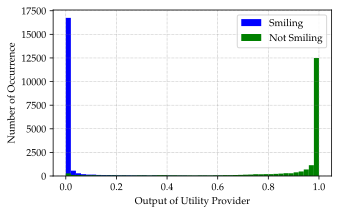

In [32]:
matplotlib.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.style.use('default')
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
fig = plt.figure(figsize=(5,3))
matplotlib.rcParams.update({'font.size': 10})
fig.tight_layout()
# plt.title("Histogram Utilizer")

plt.hist(x01, 50, color='blue', label='Smiling')
plt.hist(x10, 50, color='green', label='Not Smiling')

plt.xlabel("Output of Utility Provider")
plt.ylabel("Number of Occurrence")
# plt.ylim([0,200])
plt.grid(color = 'gray', linestyle = 'dotted', linewidth = 0.5)
plt.legend(frameon=True)
plt.savefig(saving_path + "hist_utl.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "hist_utl.png", bbox_inches = 'tight')
plt.savefig(saving_path + "hist_utl.eps", bbox_inches = 'tight', format='eps')
plt.show()

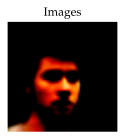

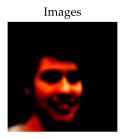

In [26]:
# Permutation case test part5:
create_random_pics = True
use_g = True
netAE.tune_noise(miu, coef_for_var, g_eff_val=-3000)
p_attr = middle_layer2[3][:]
p_attr = p_attr.reshape(torch.Size([1, 1022]))
n_attr1 = (torch.Tensor([[1, 0]])).to(device)
n_attr2 = (torch.Tensor([[0, 1]])).to(device)
netAE.change_mode('use')
netAE.eval()
output1, label1 = netAE.forward(p_attr, n_attr1)
output2, label2 = netAE.forward(p_attr, n_attr2)

plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(vutils.make_grid(output1, padding=2, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Images")
plt.imshow(np.transpose(vutils.make_grid(output2, padding=2, normalize=True).cpu(),(1,2,0)))

In [27]:
# extract utl attr and figure it out
create_random_pics = False
use_g = False
netAE.tune_noise(miu=0, coef_for_var=0, g_eff_val=0)
n1 = []
n2 = []
prog_bar = tqdm(enumerate(new_loader), total=len(new_loader))
with torch.no_grad():
  for i, data in prog_bar:
    netAE.change_mode('use')
    netAE.eval()
    inputs, labels = data[0], data[1]
    inputs = inputs.to(device)
    gender_target = extract_targets(labels)
    output, n_attr, p_attr = netAE.forward(inputs, gender_target)
    n1.append(torch.exp(n_attr[0][0]).item())
    n2.append(torch.exp(n_attr[0][1]).item())


100%|██████████| 19962/19962 [01:59<00:00, 167.47it/s]


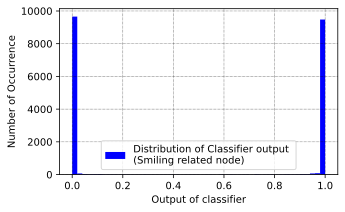

In [28]:
matplotlib.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(5,3))
fig.tight_layout()
# plt.title("Histogram Classifier")

plt.hist(n1, 50, color='blue', label='Distribution of Classifier output \n(Smiling related node)')

plt.xlabel("Output of classifier")
plt.ylabel("Number of Occurrence")
# plt.ylim([0,200])
plt.grid(color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.legend(frameon=True)
plt.savefig(saving_path + "hist_classifier.svg", bbox_inches = 'tight')
plt.savefig(saving_path + "hist_classifier.png", bbox_inches = 'tight')
plt.savefig(saving_path + "hist_classifier.eps", bbox_inches = 'tight', format='eps')
plt.show()

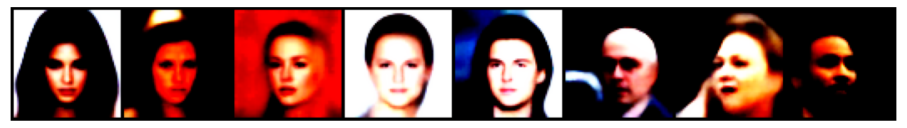

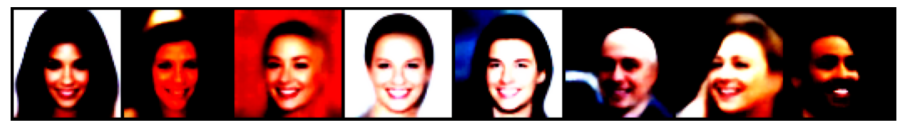

In [29]:
create_random_pics = True
use_g = True
netAE.tune_noise(miu, coef_for_var, g_eff_val=-3000)
selected_indices = [4, 100, 212, 26, 85, 158, 821, 400]
o1 = torch.empty((0, 3, 64, 64), dtype=torch.float32)
o1 = o1.to(device)
o2 = torch.empty((0, 3, 64, 64), dtype=torch.float32)
o2 = o2.to(device)

for i in selected_indices:
  p_attr = middle_layer2[i][:]
  p_attr = p_attr.reshape(torch.Size([1, 1022]))
  n_attr1 = (torch.Tensor([[1, 0]])).to(device)
  n_attr2 = (torch.Tensor([[0, 1]])).to(device)
  netAE.change_mode('use')
  netAE.eval()
  output1, label1 = netAE.forward(p_attr, n_attr1)
  output2, label2 = netAE.forward(p_attr, n_attr2)
  o1 = torch.cat([o1, output1])
  o2 = torch.cat([o2, output2])

plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(o1.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(saving_path + "modified_pics_by_only_g10.png")
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(o2.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(saving_path + "modified_pics_by_only_g01.png")

In [30]:
# Plot some images with corresponding labels
# first_batch = next(iter(test_loader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# print((first_batch[1][0])[:,39])